# Tutorial 03 - Continual Learning

It is common that a vanilla learning from scratch is interrupted and to be carried on. For such, we can start a continual learning process based on the pretrained model.  
To demonstrate, we will start from where we left off in the previous tutorial `Tutorial 02 - Vanilla Learning`. You will see in the following:
* how to load a pretrained model and a saved environment wrapper
* how to carry out a continual learning

Note that all funcionalities/code snippets from this tutorial are provided in `./commonroad_rl/train_model.py`. Please use the full functionality of `train_model.py` to perform your other experiments.

## 0. Preparation

Please make sure `Tutorial 02 - Vanilla Learning` has been followed correctly and the followings:
* current path is at `commonroad-rl/commonroad_rl`, i.e. one upper layer to the `tutorials` folder
* interactive python kernel is triggered from the correct environment

In [2]:
# Check current path
%cd ..
%pwd

# Check interactive python kernel
import sys
sys.executable

/home/shuaiyi/Documents/Lab/commonroad/commonroad-rl/commonroad_rl


'/home/shuaiyi/Downloads/ENTER/envs/commonroad-py39-rl/bin/python'

## 1. Reuse configurations and hyperparameters

Again, before the learning begins, both the RL environment and the RL model have to be set. We simply reuse the environment configurations and model hyperparameters which are saved previously.

In [3]:
import os
import yaml
import copy

log_path = "tutorials/logs/"

# Read in environment configurations
env_configs = {}
with open(os.path.join(log_path, "environment_configurations.yml"), "r") as config_file:
    env_configs = yaml.safe_load(config_file)

# Read in model hyperparameters
hyperparams = {}
with open(os.path.join(log_path, "model_hyperparameters.yml"), "r") as hyperparam_file:
    hyperparams = yaml.safe_load(hyperparam_file)

# Deduce `policy` from the pretrained model
if "policy" in hyperparams:
    del hyperparams["policy"]
    
# Remove `normalize` as it will be handled explicitly later
if "normalize" in hyperparams:
    del hyperparams["normalize"]
    

## 2. Create a training and testing environment

Similar to the previous tutorial, we create a training and testing environment for the continual learning process. However, note that we need not to explicitly wrap the vectorized training environment with the `VecNormalize` wrapper because we will later load it from the saved file.

In [4]:
# import gym
# from stable_baselines.bench import Monitor
# from stable_baselines.common.vec_env import DummyVecEnv, VecNormalize
# from stable_baselines.common.callbacks import BaseCallback, EvalCallback

import gymnasium as gym
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env  import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback

import commonroad_rl.gym_commonroad

# Create a Gym-based RL environment with specified data paths and environment configurations
meta_scenario_path = "tutorials/data/highD/pickles/meta_scenario"
training_data_path = "tutorials/data/highD/pickles/problem_train"
training_env = gym.make("commonroad-v1", 
                        meta_scenario_path=meta_scenario_path,
                        train_reset_config_path= training_data_path,
                        **env_configs)

# Wrap the environment with a monitor to keep an record of the learning process
info_keywords=tuple(["is_collision", \
                     "is_time_out", \
                     "is_off_road", \
                     "is_friction_violation", \
                     "is_goal_reached"])
training_env = Monitor(training_env, log_path + "0", info_keywords=info_keywords)

# Vectorize the environment with a callable argument
def make_training_env():
    return training_env
training_env = DummyVecEnv([make_training_env])

# Append the additional key for the testing environment
env_configs_test = copy.deepcopy(env_configs)
env_configs_test["test_env"] = True

# Create the testing environment
testing_data_path = "tutorials/data/highD/pickles/problem_test"
testing_env = gym.make("commonroad-v1", 
                        meta_scenario_path=meta_scenario_path,
                        test_reset_config_path= testing_data_path,
                        **env_configs_test)

# Wrap the environment with a monitor to keep an record of the testing episodes 
log_path_test = "tutorials/logs/test"
os.makedirs(log_path_test, exist_ok=True)

testing_env = Monitor(testing_env, log_path_test + "/0", info_keywords=info_keywords)

# Vectorize the environment with a callable argument
def make_testing_env():
    return testing_env
testing_env = DummyVecEnv([make_testing_env])

# Normalize only observations during testing
testing_env = VecNormalize(testing_env, norm_obs=True, norm_reward=False, training=False)

# Define a customized callback function to save the vectorized and normalized training environment
class SaveVecNormalizeCallback(BaseCallback):
    def __init__(self, save_path: str, verbose=1):
        super(SaveVecNormalizeCallback, self).__init__(verbose)
        self.save_path = save_path
        
    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    
    def _on_step(self) -> bool:
        save_path_name = os.path.join(self.save_path, "vecnormalize.pkl")
        self.model.get_vec_normalize_env().save(save_path_name)
        print("Saved vectorized and normalized environment to {}".format(save_path_name))
        return True
    
# Pass the testing environment and customized saving callback to an evaluation callback
# Note that the evaluation callback will triggers three evaluating episodes after every 500 training steps
save_vec_normalize_callback = SaveVecNormalizeCallback(save_path=log_path)
eval_callback = EvalCallback(testing_env, 
                             log_path=log_path, 
                             eval_freq=500, 
                             n_eval_episodes=3, 
                             callback_on_new_best=save_vec_normalize_callback)

2025-03-21 15:41:56.667339: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 15:41:56.673639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742568116.681633   58522 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742568116.684023   58522 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 15:41:56.691716: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[gym_commonroad/__init__.py] Registered commonroad-v1


[DEBUG] commonroad_rl.gym_commonroad.commonroad_env - Initialization started
[INFO] commonroad_rl.gym_commonroad.commonroad_env - Training on tutorials/data/highD/pickles/problem_train with 35 scenarios
/home/shuaiyi/Downloads/ENTER/envs/commonroad-py39-rl/lib/python3.9/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/shuaiyi/Downloads/ENTER/envs/commonroad-py39-rl/lib/python3.9/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
[DEBUG] commonroad_rl.gym_commonroad.commonroad_env - Meta scenario path: tutorials/data/highD/pickles/meta_scenario
[DEBUG] commonroad_rl.gym_commonroad.commonroad_env - Training data path: tutorials/data/highD/pickles/problem_train
[DEBUG] commonroad_rl.gym_commonroad.commonroad_env - Testing data path: /home/shuaiyi/Documents/Lab/commonro

## 3. Load the saved environment wrapper and pretrained agent

Now we load the saved environment wrapper and the pretrained agent for the continual learning process.

In [5]:
# from stable_baselines.common.vec_env import VecNormalize
# from stable_baselines import PPO2

from stable_baselines3.common.vec_env  import VecNormalize
from stable_baselines3 import PPO

# Load saved environment
training_env = VecNormalize.load("tutorials/logs/vecnormalize.pkl", training_env)

# Load pretrained model
# model_continual = PPO2.load("tutorials/logs/intermediate_model", env=training_env, **hyperparams)
model_continual = PPO.load("tutorials/logs/intermediate_model", env=training_env, **hyperparams)

/home/shuaiyi/Downloads/ENTER/envs/commonroad-py39-rl/lib/python3.9/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


## 3. Conduct learning and save results
Finally, we trigger the continual learning process in a similar fashion as before, and save the final model as well as the environment wrapper for later inspection.

/home/shuaiyi/Documents/Lab/commonroad/commonroad-rl/external/commonroad-io/commonroad/scenario/lanelet.py:734: DeprecationWarning: Use the lanelet property <polygon> instead
  warnings.warn("Use the lanelet property <polygon> instead", DeprecationWarning)


Eval num_timesteps=500, episode_reward=411.29 +/- 332.76
Episode length: 34.67 +/- 7.13


/home/shuaiyi/Documents/Lab/commonroad/commonroad-rl/external/commonroad-io/commonroad/scenario/lanelet.py:734: DeprecationWarning: Use the lanelet property <polygon> instead
  warnings.warn("Use the lanelet property <polygon> instead", DeprecationWarning)


Eval num_timesteps=1000, episode_reward=681.47 +/- 659.04
Episode length: 49.67 +/- 13.20
Eval num_timesteps=1500, episode_reward=86.72 +/- 244.87
Episode length: 39.33 +/- 6.80


/home/shuaiyi/Documents/Lab/commonroad/commonroad-rl/external/commonroad-io/commonroad/scenario/lanelet.py:734: DeprecationWarning: Use the lanelet property <polygon> instead
  warnings.warn("Use the lanelet property <polygon> instead", DeprecationWarning)


Eval num_timesteps=2000, episode_reward=266.84 +/- 91.55
Episode length: 41.00 +/- 3.27


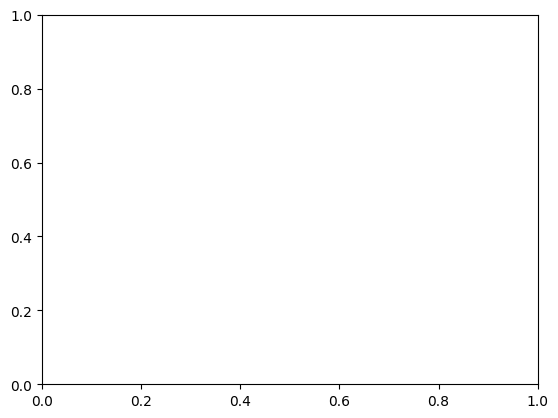

In [10]:
# Set learning steps and trigger learning with the evaluation callback
n_timesteps=2000
model_continual.learn(n_timesteps, eval_callback)

# Save the continual-learning model
# Note that we use the name "best_model" here as it will be fetched in the next tutorials
model_continual.save("tutorials/logs/best_model")
model_continual.get_vec_normalize_env().save("tutorials/logs/vecnormalize.pkl")

In [ ]:
# Specify the filename and save the model
model_continual.save("tutorials/logs/intermediate_model")